<a href="https://colab.research.google.com/github/hodosimate/hodosimate.github.io/blob/main/GPD_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Crypto winter 2022**

The crypto winter of 2022 marked a prolonged downturn in the cryptocurrency market, with Bitcoin’s price collapsing from nearly 69,000 USD in late 2021 to around 16,000 USD by the end of 2022.

This decline was fueled by rising interest rates, tightening liquidity, and major industry failures such as the collapses of Terra/Luna and FTX.
Investor confidence plummeted, leading to widespread liquidations, layoffs, and reduced trading activity across the crypto sector.

We examine how Value at Risk (VaR) and Expected Shortfall (ES) can be calculated during periods of market distress, when returns are highly volatile and non-normal.
In such times, traditional models often underestimate risk, so tail-focused methods like Extreme Value Theory (EVT) can used to better capture extreme losses.
This allows for more accurate estimation of downside risk, reflecting the heightened uncertainty and fat-tailed nature of distressed market conditions.

Used Python packages

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

Usual yfinance parameters and data download

In [4]:
tickers = ["BTC-USD"]
start, end = "2020-01-01", "2023-12-31"
df = yf.download(tickers, start=start, end=end)["Close"].dropna()

/tmp/ipython-input-937711279.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start, end=end)["Close"].dropna()
[*********************100%***********************]  1 of 1 completed


Confidence interval and timeframe for Value at Risk (VaR) and Expected Shortfall (ES) calculations.

In [5]:
window = 10
alpha = 0.01
z_99 = stats.norm.ppf(1 - alpha)

Rolling window returns mean and volatility calculation.

In [6]:
returns = np.log(df / df.shift(1)).dropna()
returns_10d=returns.rolling(window).sum().dropna()
sigma_10d=returns_10d.std()

Parametric VaR and ES calculation (note that this method involves the assumption of normal distribution in log-returns).

In [7]:
var_99_parametric0=-sigma_10d*z_99
var_99_parametric=var_99_parametric0.values[0]
es_99_parametric0 = - sigma_10d * stats.norm.pdf(z_99) / alpha
es_99_parametric=es_99_parametric0.values[0]
print(var_99_parametric)
print(es_99_parametric)

-0.2656788805549104
-0.30437886715135


Monte Carlo VaR and ES calculation (note that the normal distribution assumption is still in play).

In [8]:
initial = df.iloc[0]

mu_annual = returns.mean() * 250
sigma_annual = returns.std() * np.sqrt(250)

np.random.seed(42)
n_simulations = 10000
n_days = window

simulated_returns = []

for _ in range(n_simulations):
    S = initial
    for _ in range(n_days):
        Z = np.random.normal()
        S = S * np.exp((mu_annual - 0.5*sigma_annual**2)/250 + sigma_annual*np.sqrt(1/250)*Z)
    simulated_return = (S - initial) / initial
    simulated_returns.append(simulated_return)

var_99_monte_carlo=np.percentile(simulated_returns, alpha*100)
simulated_returns=np.array(simulated_returns)
es_99_monte_carlo = simulated_returns[simulated_returns <= var_99_monte_carlo].mean()
print(var_99_monte_carlo)
print(es_99_monte_carlo)

-0.2253892555461662
-0.24924372779865078


Historic VaR and ES calculation (note that this is the method that has no assumptions about the underlying distribution).

In [9]:
returns_10d=returns.rolling(window).sum().dropna()
returns_10d_sorted=returns_10d.apply(np.sort, axis=0)
num_instance=round(np.size(returns_10d_sorted)*alpha)
var_99_historic=returns_10d_sorted.iloc[num_instance].values[0]
tail_losses = returns_10d_sorted.iloc[:num_instance]
es_99_historic = tail_losses.mean().values[0]
print(var_99_historic)
print(es_99_historic)

-0.3449128741787692
-0.46947859862439273


As one can notice the different calculations have a very different picture about the Bitcoins risk measurement in this timeframe.

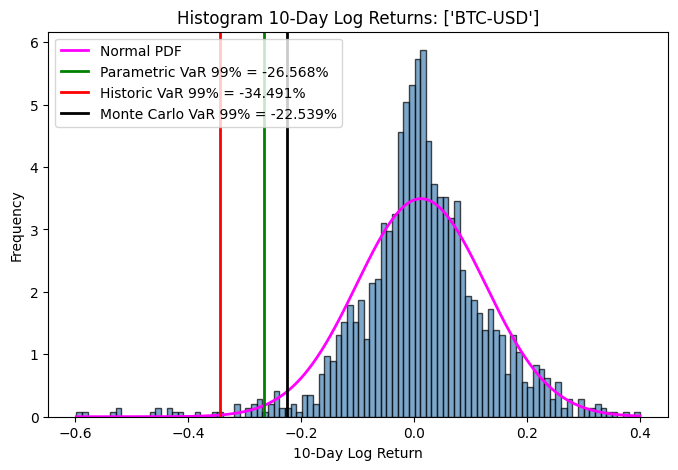

In [10]:
x = np.linspace(returns_10d.min(), returns_10d.max(), 500)
pdf = stats.norm.pdf(x, returns_10d.mean(), returns_10d.std())
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(returns_10d, bins=100, color='steelblue', edgecolor='black', alpha=0.7, density=True)
ax.set_title(f"Histogram 10-Day Log Returns: {tickers}")
ax.set_xlabel("10-Day Log Return")
ax.set_ylabel("Frequency")
ax.plot(x, pdf, color='magenta', linewidth=2, label='Normal PDF')
ax.axvline(var_99_parametric, color='green', linewidth=2, label=f'Parametric VaR 99% = {var_99_parametric*100:.3f}%')
ax.axvline(var_99_historic, color='red', linewidth=2, label=f'Historic VaR 99% = {var_99_historic*100:.3f}%')
ax.axvline(var_99_monte_carlo, color='black', linewidth=2, label=f'Monte Carlo VaR 99% = {var_99_monte_carlo*100:.3f}%')
ax.legend()
plt.show()

The reason behind this is the assumption of normal distribution in the Parametric and Monte Carlo methods and the lack of any assumption in the Historic method. As one can see in the following Q-Q plot the underlying distribution is fat-tailed and being that far from normal.

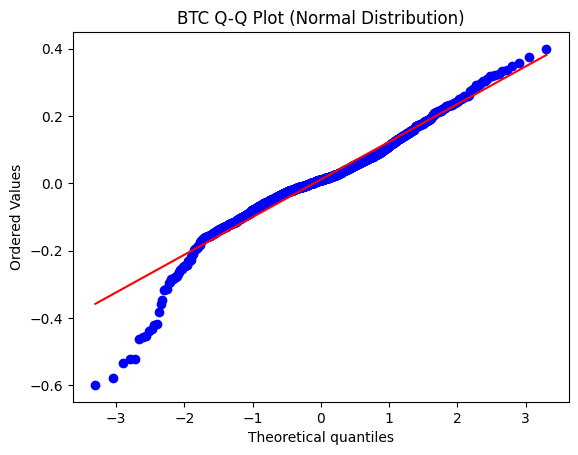

In [11]:
stats.probplot(returns_10d.values.flatten(), dist=stats.norm, plot=plt)
plt.title("BTC Q-Q Plot (Normal Distribution)")
plt.show()

Why not just stop there, call it a day, and use Historic VaR and ES from now on?

The answer is that it’s not that simple. Historic VaR also has its limitations. Nevertheless, it remains widely used due to its simplicity and because, as we’ll see later, model-based approaches typically yield higher VaR and ES values — which, in turn, lower the Return on Equity, the main objective of any firm’s management.

The limitaions are: it cannot be reliably extrapolated, becomes unstable when there are too few extreme observations, cannot account for extreme events that have not yet occurred, and is highly sample-dependent.

Now that we concluded, normal distribution cannot be used because of the fat tails of the empirical density. We can try Student's t-distribution (df=4), as this is debated to be the real underlying distribution of stock returns (along with Lévy alpha-stable distribution (alpha=1.4), but that's a whole another discussion).

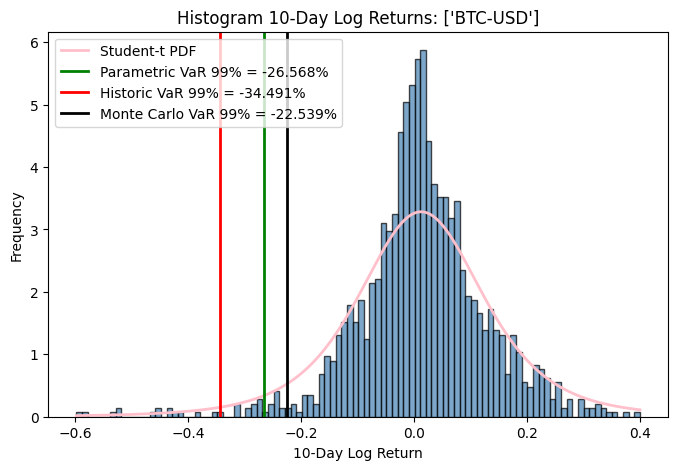

In [12]:
z_99 = stats.t.ppf(1 - alpha,4)
var_99_parametric0_t=-sigma_10d*z_99
var_99_parametric_t=var_99_parametric0.values[0]

simulated_returns = []

for _ in range(n_simulations):
    S = initial
    for _ in range(n_days):
        Z = np.random.standard_t(df=4)
        S = S * np.exp((mu_annual - 0.5*sigma_annual**2)/250 + sigma_annual*np.sqrt(1/250)*Z)
    simulated_return = (S - initial) / initial
    simulated_returns.append(simulated_return)

var_99_monte_carlo_t=np.percentile(simulated_returns, alpha*100)

fig, ax = plt.subplots(figsize=(8,5))
ax.hist(returns_10d, bins=100, color='steelblue', edgecolor='black', alpha=0.7, density=True)
ax.set_title(f"Histogram 10-Day Log Returns: {tickers}")
ax.set_xlabel("10-Day Log Return")
ax.set_ylabel("Frequency")
x = np.linspace(returns_10d.min(), returns_10d.max(), 500)
pdf = stats.t.pdf(x, 4, loc=returns_10d.mean(),scale=returns_10d.std())
ax.plot(x, pdf, color='pink', linewidth=2, label='Student-t PDF')
ax.axvline(var_99_parametric, color='green', linewidth=2, label=f'Parametric VaR 99% = {var_99_parametric*100:.3f}%')
ax.axvline(var_99_historic, color='red', linewidth=2, label=f'Historic VaR 99% = {var_99_historic*100:.3f}%')
ax.axvline(var_99_monte_carlo, color='black', linewidth=2, label=f'Monte Carlo VaR 99% = {var_99_monte_carlo*100:.3f}%')
ax.legend()
plt.show()

Still not quite there, as the following Q-Q plot shows, t (df=4) distribution doesn't model the returns well enough.

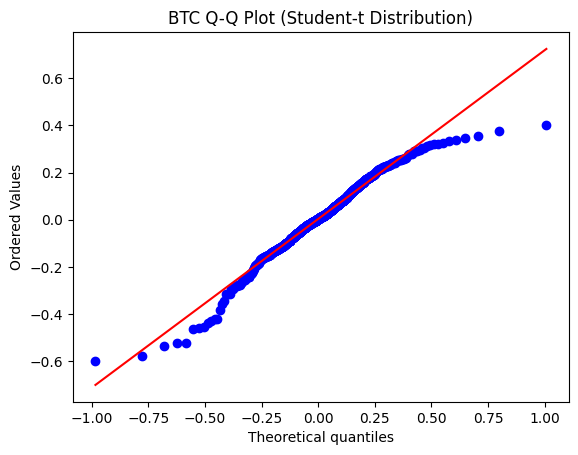

In [13]:
stats.probplot(returns_10d.values.flatten(), dist=stats.t,sparams=(4, returns_10d.mean(), sigma_10d), plot=plt)
plt.title("BTC Q-Q Plot (Student-t Distribution)")
plt.show()

Now comes the interesting part, let's fit a Generalized Pareto Distribution (GPD) to the left tail of the returns empirical denstity (e.g. the losses).

\begin{equation}
  F_{\mu,\sigma,\xi}(x) =
  \begin{cases}
    1 - \left(1 + \dfrac{\xi (x - \mu)}{\sigma}\right)^{-1/\xi}, & \text{if } \xi \neq 0, \\[1em]
    1 - \exp\!\left(-\dfrac{x - \mu}{\sigma}\right), & \text{if } \xi = 0,
  \end{cases}
\end{equation}

This model is essentially designed for this purpose. It has three parameters: location, scale, and shape. The location parameter will be set to zero, since I will define the threshold myself—that is, the point above which values are considered extreme.

To determine this threshold, I use the Mean Residual Life (MRL) plot. The MRL plot shows the average of exceedances above different threshold levels. At first, the plot appears flat and noisy, as the tail behavior has not yet separated from the bulk of the data. Then it becomes a steep, roughly linear section—this is where the assumption that the tail can be modeled by a GPD begins to hold. Beyond that, the plot becomes flat and noisy again due to too few exceedances.

The threshold should be chosen within this linear region; in this case, it was set at 0.14 (e.g. the losses count as extreme, if they are worse than 14% loss).

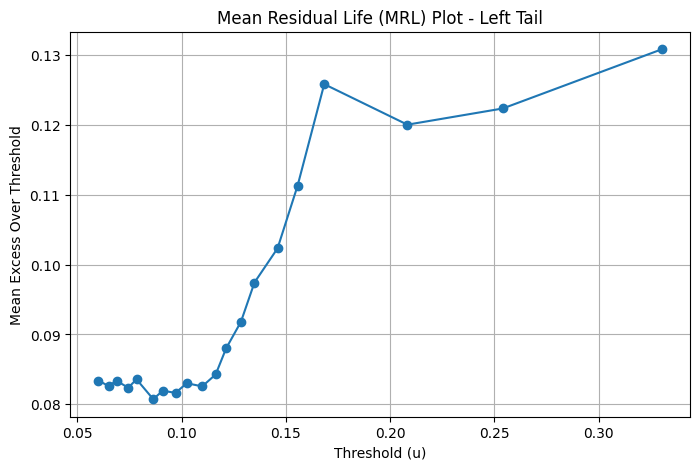

In [14]:
returns_10d_flat=np.asanyarray(returns_10d).flatten()

losses=-returns_10d_flat

thresholds=np.quantile(losses, np.linspace(0.8, 0.99, 20))

mean_exceedances=[]

for u in thresholds:
    exeedances=losses[losses>u]-u
    mean_exceedances.append(exeedances.mean())


plt.figure(figsize=(8,5))
plt.plot(thresholds, mean_exceedances, marker='o')
plt.xlabel("Threshold (u)")
plt.ylabel("Mean Excess Over Threshold")
plt.title("Mean Residual Life (MRL) Plot - Left Tail")
plt.grid(True)
plt.show()

We can conclude if the fitted GPD is close enough to the original data by checking the Cummulative Distribution Function (CDF), and the Probability Distribution Function (PDF).

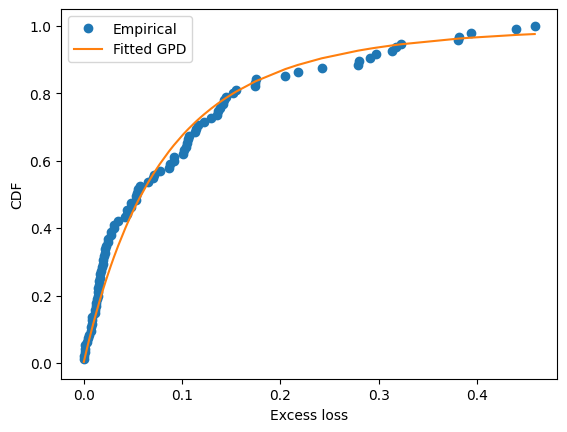

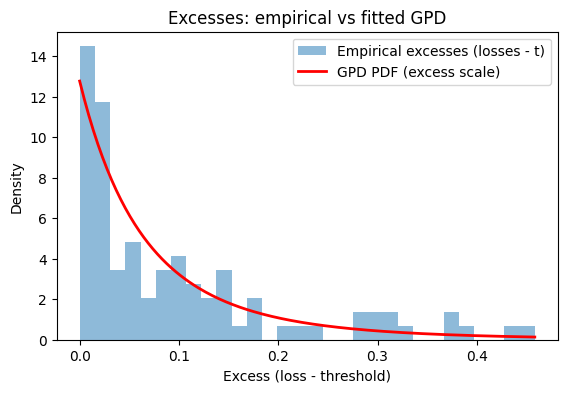

GPD location parameter: 0.000
GPD scale parameter: 0.078
GPD shape parameter: 0.226


In [23]:
threshold=0.14
excesses=losses[losses>threshold]-threshold

c_gpd, loc_gpd, scale_gpd = stats.genpareto.fit(excesses, floc=0)

sorted_excesses=np.sort(excesses)
ecdf = np.arange(1, len(sorted_excesses)+1) / len(sorted_excesses)
gpd_cdf = stats.genpareto.cdf(sorted_excesses, c_gpd, loc=loc_gpd, scale=scale_gpd)
plt.plot(sorted_excesses, ecdf, marker='o', linestyle='none', label="Empirical")
plt.plot(sorted_excesses, gpd_cdf, label="Fitted GPD")
plt.xlabel("Excess loss")
plt.ylabel("CDF")
plt.legend()
plt.show()

plt.figure(figsize=(6.46,4))
plt.hist(excesses, bins=30, density=True, alpha=0.5, label="Empirical excesses (losses - t)")
e_vals = np.linspace(0,excesses.max(), 200)
plt.plot(e_vals, stats.genpareto.pdf(e_vals, c_gpd, loc=0, scale=scale_gpd), 'r-', lw=2, label="GPD PDF (excess scale)")
plt.xlabel("Excess (loss - threshold)")
plt.ylabel("Density")
plt.title("Excesses: empirical vs fitted GPD")
plt.legend()
plt.show()

print(f"GPD location parameter: {loc_gpd:.3f}")
print(f"GPD scale parameter: {scale_gpd:.3f}")
print(f"GPD shape parameter: {c_gpd:.3f}")

We can derive the VaR and ES formulas from the GPD PDF (note that the new fitted GPD does not model the whole distribution of the returns, but above a certain confidence level, to be more precise beyond the threshold of extreme values, we can trust our only the fitted left tail to model the risk in question). The calculated VaR and ES will be quite close to the values obtained with the Historic method. With confidence levels beyond this examples 99%, the difference is greater and greater, the GPD-fitted VaR and ES will exceed the Historic. However one cannot decide if this can be considered overestimation, simply because GPD also accounts losses that are yet to occur in the sample and have considerably smaller possibility.

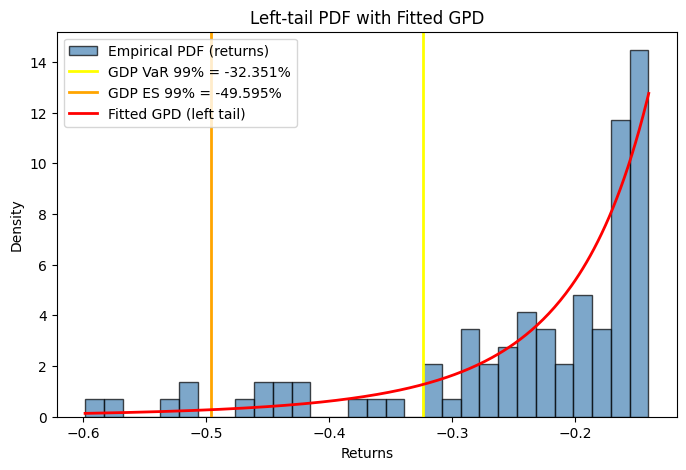

In [18]:
num_sample=np.size(returns_10d)
num_excesses=np.size(excesses)
var_gpd=-threshold-scale_gpd/c_gpd*((alpha/(num_excesses/num_sample))**-c_gpd-1)
es_gpd=(var_gpd-((scale_gpd-c_gpd*threshold)/(1-c_gpd)))/(1-c_gpd)

fig, ax = plt.subplots(figsize=(8,5))
left_tail_returns = returns_10d_flat[returns_10d_flat < -threshold]
ax.hist(left_tail_returns, bins=30, density=True, alpha=0.7, color='steelblue', edgecolor='black', label="Empirical PDF (returns)")
ax.axvline(var_gpd, color='yellow', linewidth=2, label=f'GDP VaR 99% = {var_gpd*100:.3f}%')
ax.axvline(es_gpd, color='orange', linewidth=2, label=f'GDP ES 99% = {es_gpd*100:.3f}%')
x = np.linspace(left_tail_returns.min(), -threshold, 300)
e_for_x = -x - threshold
pdf_gpd = stats.genpareto.pdf(e_for_x, c_gpd, loc=0, scale=scale_gpd)

ax.plot(x, pdf_gpd, 'r-', lw=2, label="Fitted GPD (left tail)")
ax.set_xlabel("Returns")
ax.set_ylabel("Density")
ax.set_title("Left-tail PDF with Fitted GPD")
ax.legend()
plt.show()

The final step is backtesting the GDP VaR. The given confidence interval 99% means that in the observed sample 1% of the losses can exceed our VaR value. The are several existing VaR backtests, here the Likelihood Ratio Unconditional Coverage (LRuc) Test is used (note that this does not take into accunt how clustered the exeedances were, only their cardinality is important).

\begin{equation}
LR_{uc} = -2 \left[ x \log{\left( \frac{p}{p^*} \right)} + (T - x)\log{\left( \frac{1 - p}{1 - p^*} \right)} \right]
\end{equation}

Likelihood ratio should be chi-squared distributed, using one degree of freedom. The VaR model will be rejected if the likelihood radio statistic exceeds the critical value of the chi-squared distribution. With the null hypotesis being that our VaR model is calibrated well, the exeedances match the given confidence level.

In [24]:
x=np.size(losses[losses>-var_gpd])
T=np.size(losses)

actual_exeptions_rate=x/T
expected_exeptions_rate=alpha

L_uc=-2*(x*np.log(expected_exeptions_rate/actual_exeptions_rate)+(T-x)*np.log((1-expected_exeptions_rate)/(1-actual_exeptions_rate)))

p_value = 1 - stats.chi2.cdf(L_uc, df=1)
print(f"L_uc = {L_uc:.3f}, p-value = {p_value:.3f}, exceptions = {x}, rate = {actual_exeptions_rate:.4f}")

L_uc = 0.017, p-value = 0.896, exceptions = 15, rate = 0.0103


The p-value shows that we cannot reject the null hypotesis, in other words, the model correctly predicts the number of VaR breaches. Our research is now concluded.